# HA 3 - GPs and TS

In this HA, you can get 40points in total
* reproducing the plots gives you full grade
* if example is not reproduced we evaluate "how many changes are required to get to the full grade"
* each change couns for 2 points

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [2]:
passengers = pd.read_csv("AirPassengers.csv", parse_dates=["Month"])

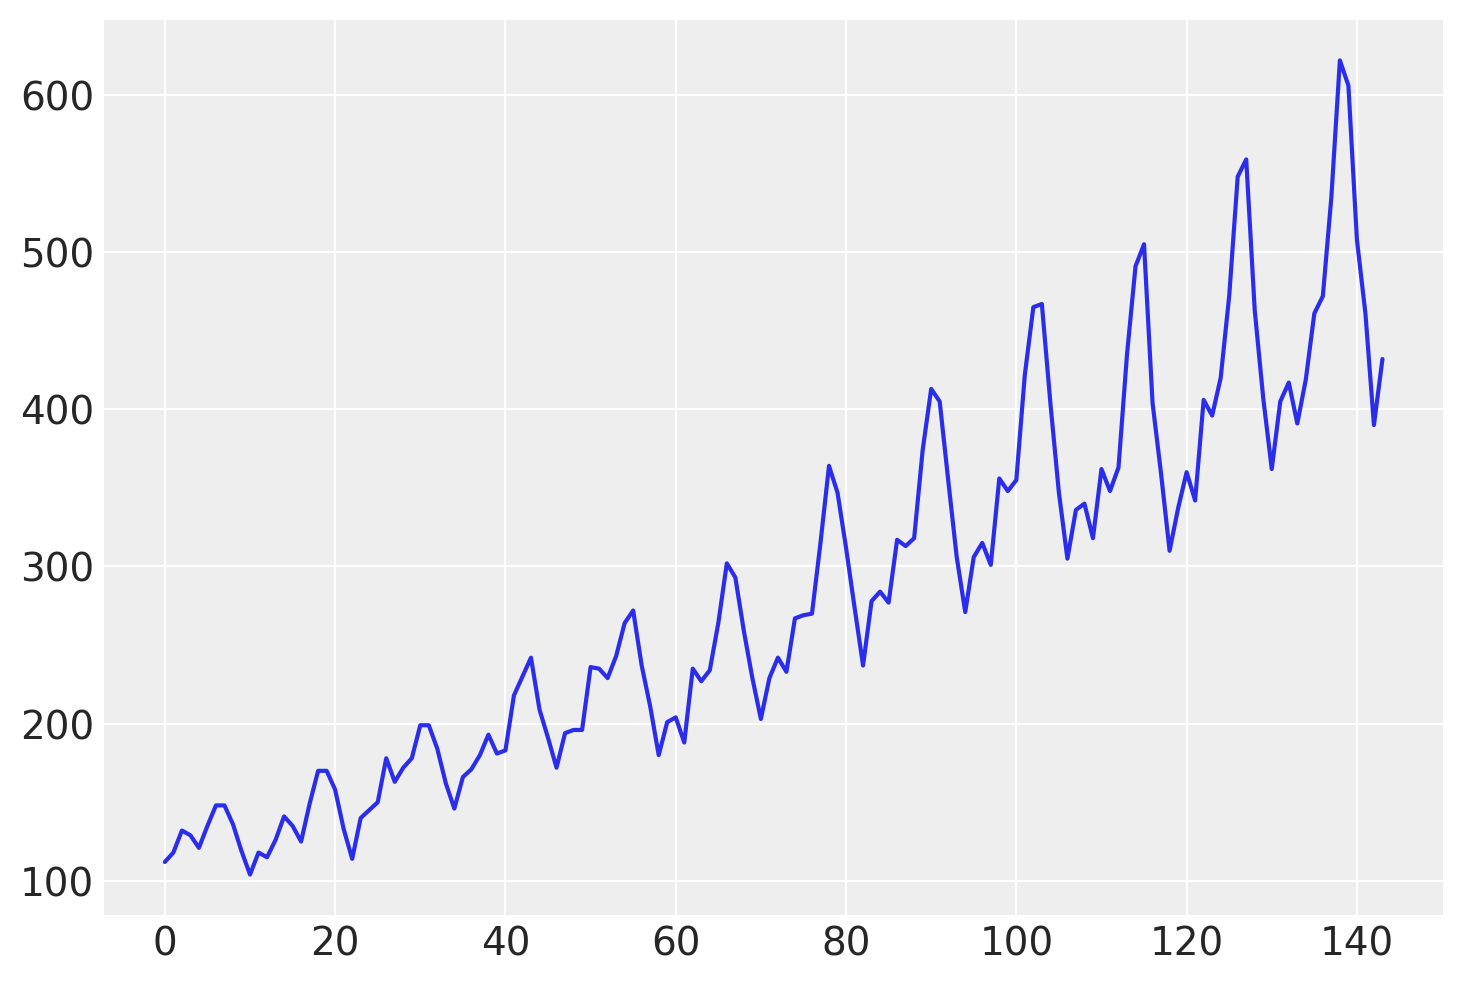

In [3]:
plt.plot(passengers["#Passengers"]);

## Part 1. Trend Model (10pt)

In this part of the home assignment, you'll need to create Marginal gaussian Process to model number of passengers.

1. You should notice, that there is decent amount of seasonality in data
2. There is also Trend in data
3. Not as useless, number of passengers is a positve number

### Practical advices

It is a common practice in applied stats to replace **a part of** prior predictive study
```python
# for data in R^n
time_series: pd.Series
marginal_std = time_series.std()
marginal_mean = time_series.mean()
# for data in R_+^n (Positive data)
marginal_log_std = np.log(time_series[time_series>0]).std()
marginal_log_mean = np.log(time_series[time_series>0]).mean()
```
This does not nessesarily replace all the investigations into "how does the model look like", but significantly improves "ease of use" of Bayesian models.

In [4]:
marginal_log_std = np.log(passengers["#Passengers"][passengers["#Passengers"]>0]).std()
marginal_log_mean = np.log(passengers["#Passengers"][passengers["#Passengers"]>0]).mean()

Fixed numbers are too concrete, so some of the uncertainty to help the model find optimal marginals is needed.

> for our log scale data, std is on the log scale for both mean and std

In [5]:
log_empirical_uncertainty = 0.15

Now, implement the model

$$
\begin{align}
\text{mlogmean} &\sim \operatorname{Normal}(\text{marginal-log-mean}, \text{log-empirical-uncertainty}) \\
\text{trend} &\sim \operatorname{Normal}(0,?) \\
\text{eps} &\sim \operatorname{LogNormal}(?,?) \\
\text{obs} &\sim \operatorname{LogNormal}(f(\text{mlogmean},\text{trend}),\text{eps})\\
\end{align}
$$

In [6]:
with pm.Model(coords=dict(time=passengers["Month"])) as model1:
    # center data such that E[X] is 0, this is a common practice to simplify reasoning
    months = pm.ConstantData("month", np.arange(len(passengers)) - len(passengers)//2, dims="time")
    m_log_mean = ...
    log_trend = ...
    log_mean = ... # compute from months, log_trend, m_log_mean
    eps = ...
    obs = pm.LogNormal("obs", log_mean, eps, observed=passengers["#Passengers"], dims="time")

In [7]:
with model1:
    prior = pm.sample_prior_predictive()

Sampling: [eps, m_log_mean, obs, trend]


Make sure number od passengers does not explode dramatically.

In [ ]:
az.plot_ppc(prior, group="prior");

In [9]:
with model1:
    trace = pm.sample()
    trace.extend(pm.sample_posterior_predictive(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_log_mean, trend, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


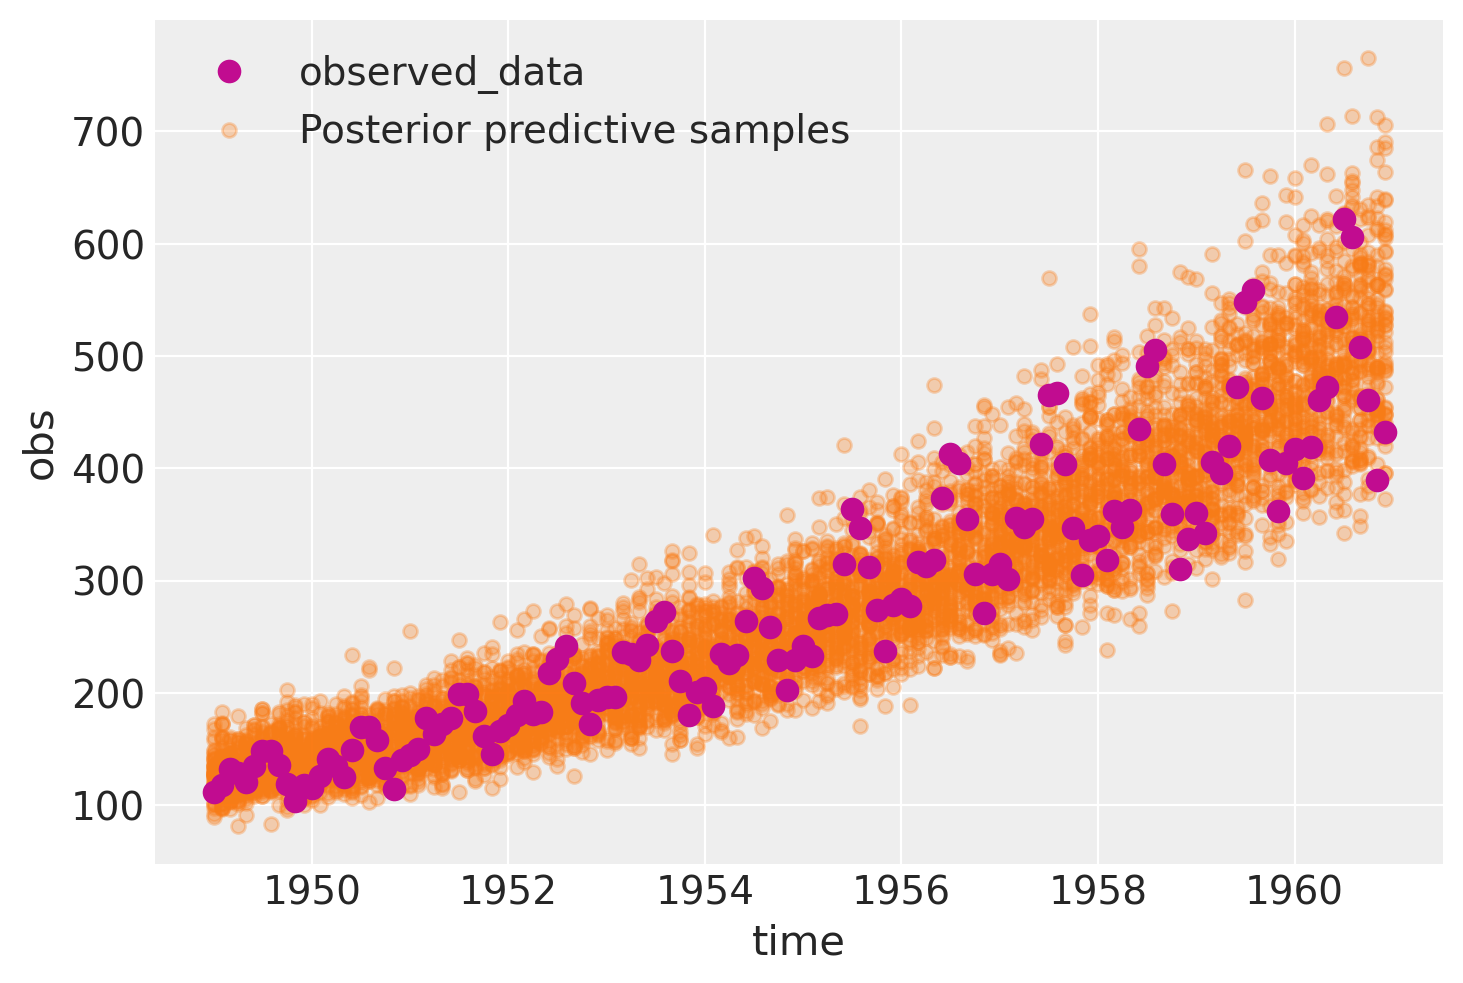

In [10]:
az.plot_lm("obs", trace);

## Part 2. Simple GP (10pt)

Copy paste your model to the nest cell, name it model2, we are going to replace the model with Gaussian Process Model

$$
\begin{align}
\text{mlogmean} &\sim \operatorname{Normal}(?,?) \\
\text{trend} &\sim \operatorname{Normal}(0,?) \\
\text{eps} &\sim \operatorname{LogNormal}(?,?) \\
\alpha_s &\sim \operatorname{LogNormal}(?, ?)\\
l_s &\sim \operatorname{Gamma}(?, ?)\\
K &= \alpha_s\operatorname{Periodic}(\text{period}=12, l_s)\\
\text{seasonal} &\sim \mathcal{GP}(\text{time}, 0, K)\\
\text{obs} &\sim \operatorname{LogNormal}(f(\text{mlogmean},\text{trend}, \text{seasonal}),\text{eps})\\
\end{align}
$$
where for $\operatorname{Periodic}(\text{period}=12, \dots)$ you should initialize **lengthscale** and **magnitude**

read
* https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html
* https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html

In [11]:
with pm.Model(coords=dict(time=passengers["Month"])) as model2:
    # center data such that E[X] is 0, this is a common practice to simplify reasoning
    months = pm.ConstantData("month", np.arange(len(passengers)) - len(passengers)//2, dims="time")

    # copy from the previous model
    m_log_mean = ...
    log_trend = ...
    log_mean = ... # compute from months, log_trend, m_log_mean
    eps = ...

    # time to implement a GP
    # priors come first
    alpha_s = ...
    # we have monthly data, take this in account
    ls = ...
    periodic = ...
    assert isinstance(periodic, pm.gp.cov.Periodic)
    
    gp = pm.gp.Latent(cov_func=periodic * alpha_s)
    seasonality = gp.prior("seasonality", months[:, None])

    pm.Normal("log_obs", log_mean + seasonality, eps, observed=np.log(passengers["#Passengers"]), dims="time")

In [ ]:
pm.model_to_graphviz(model2)

We are going to use fins MAP to quickly esimate the GP

In [29]:
with model2:
    map = pm.find_MAP()
    ppc = pm.sample_posterior_predictive([map]*100)

Sampling: [log_obs]


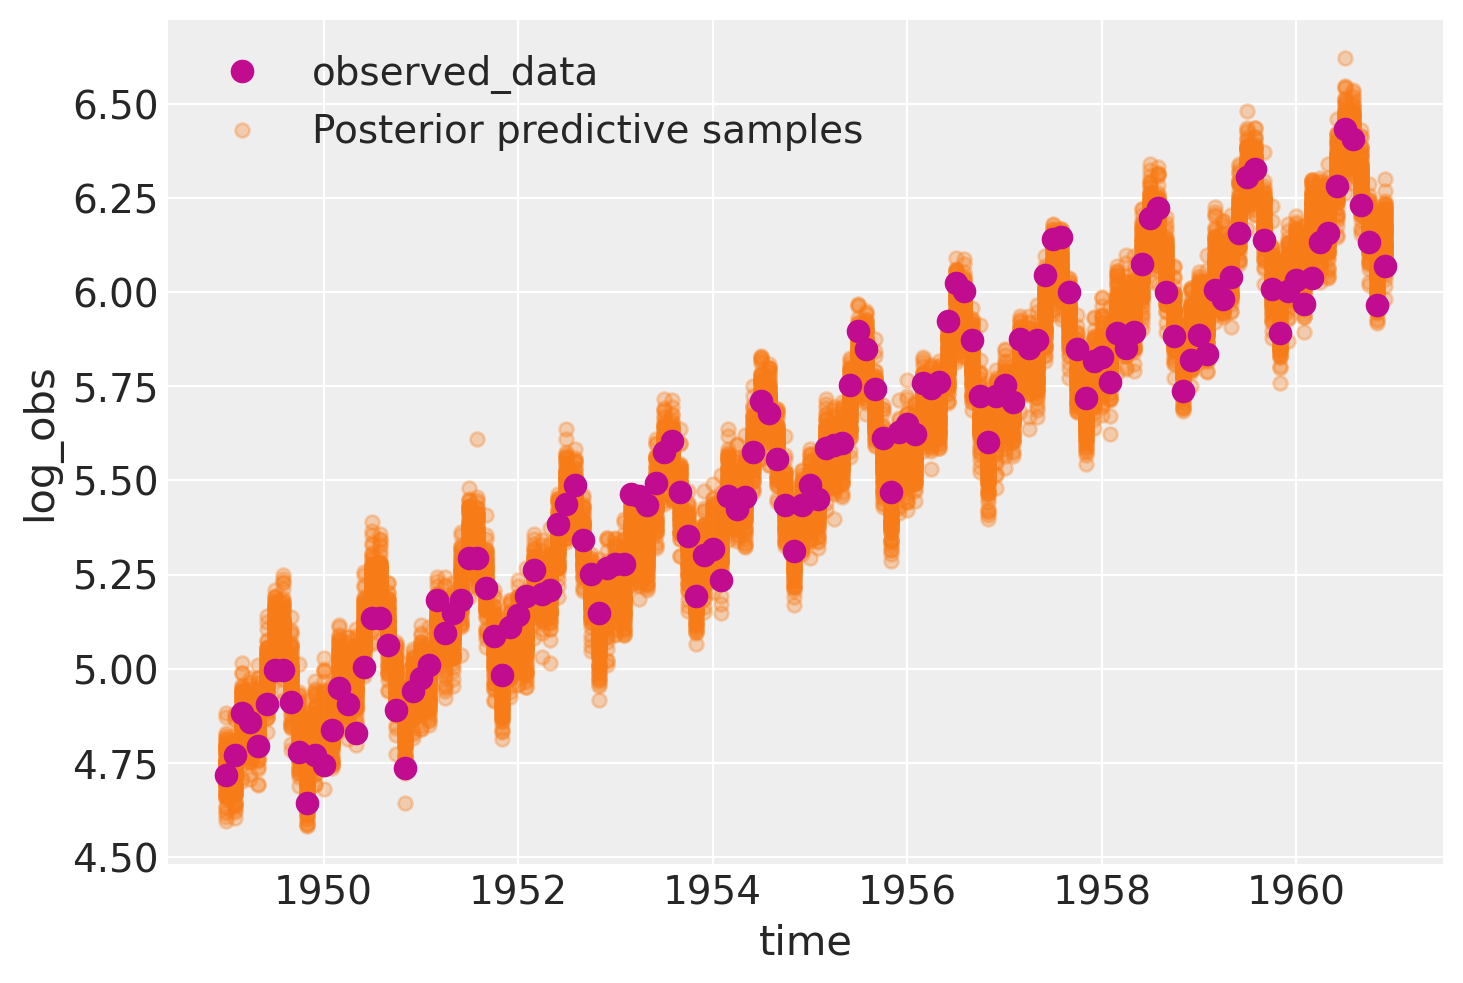

In [30]:
az.plot_lm("log_obs", ppc, num_samples=100);

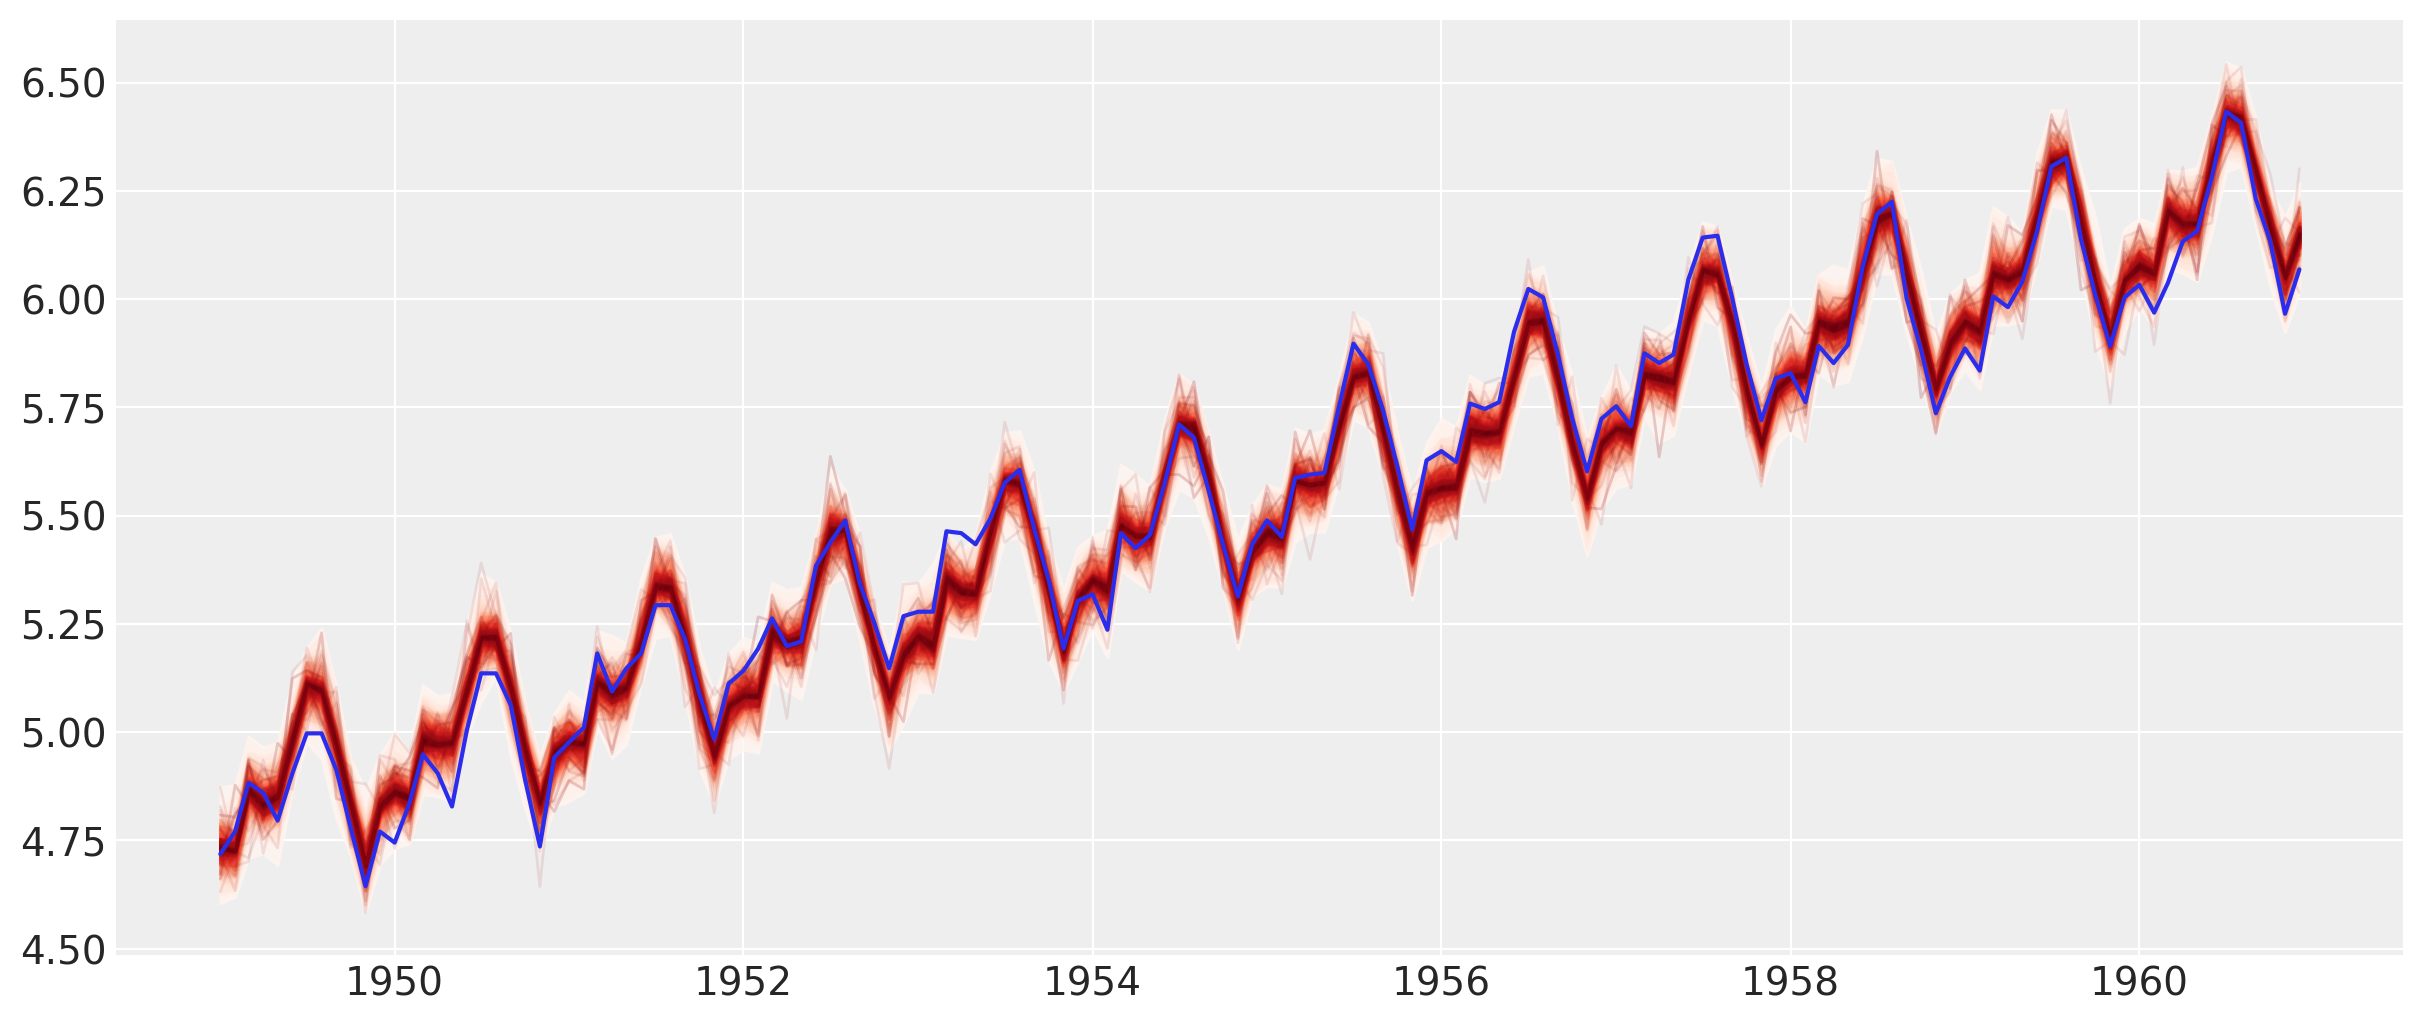

In [31]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()


plot_gp_dist(ax, az.extract(ppc.posterior_predictive)["log_obs"].T, ppc.posterior_predictive.time.values)
ax.plot(ppc.posterior_predictive.time.values, np.log(passengers["#Passengers"]));

You can try running simple sampling, but it will be not as fast and there will be diverging samples.

> This is optional, you can do it out of your curiosity

In [16]:
with model2:
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_log_mean, trend, alpha_s, ls_s, eps, seasonality_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 367 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
with model2:
    ppc_large = pm.sample_posterior_predictive(trace2)

Sampling: [log_obs]


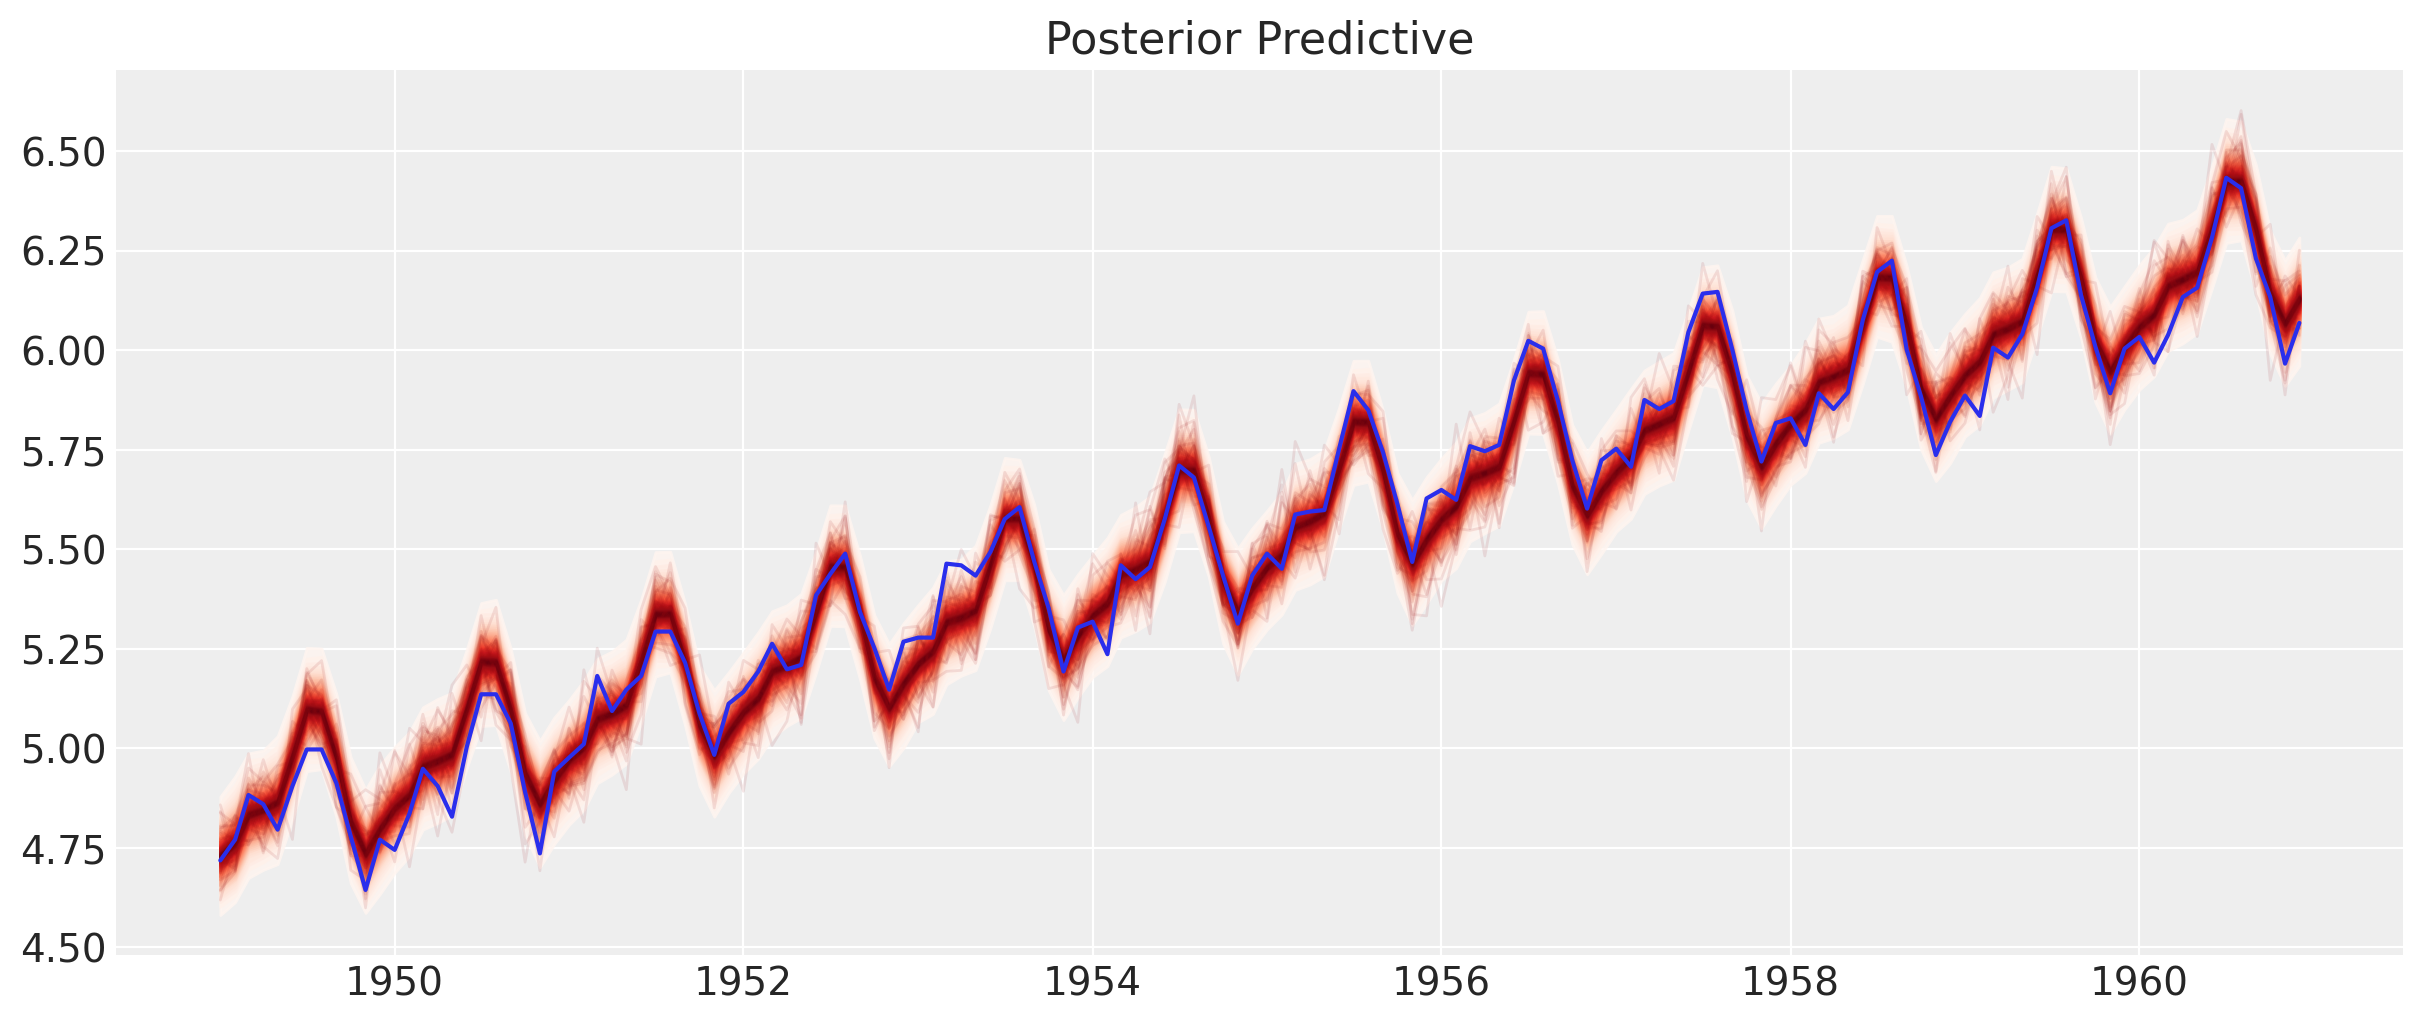

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()


plot_gp_dist(ax, az.extract(ppc_large.posterior_predictive)["log_obs"].T, ppc_large.posterior_predictive.time.values)
ax.plot(ppc_large.posterior_predictive.time.values, np.log(passengers["#Passengers"]))
plt.title("Posterior Predictive");

## Part 3. Fourier features (10pt)

The gaussian process we created is slow in sampling. Practitioners rarely use GPs like above because of that.

There are practical approaches to deal with seasonal time series models. One of the most favorite one is fourier features.

* https://arxiv.org/abs/2006.10739
* Prophet uses Fourier features https://github.com/facebook/prophet/blob/c00f6a2d72229faa6acee8292bc01e14f16f599c/python/prophet/forecaster.py#L455
* These should not be underestimated

To make practical use of them, here is the snippet to create these features given required periodicity.

In [32]:
from collections import namedtuple
from enum import Enum

Season = namedtuple("Season", "period,order")

class Daily(Season, Enum):
    Week = 7.0, 3
    Year = 365.25, 5
    Month = 365.25 / 12, 10

class Monthly(Season, Enum):
    Year = 12, 5
    Month = 1, 10

In [33]:
Daily.Year

<Daily.Year: Season(period=365.25, order=5)>

In [34]:
def fourier_series(
    time: pt.TensorLike, 
    *, 
    season: Season,
) -> pt.TensorVariable:
    """Generate Fourier Series.

    Parameters
    ----------
    time : pt.TensorLike
        Time Dimension
    season: Season
        Contains period and order of approximation

    Returns
    -------
    pt.TensorVariable
        Fourier basis functions scaled to have unit variance across time dimension
    """
    if (season.order * 2) > season.period:
        raise ValueError("(season.order * 2) > season.period length causes correlated feature")
    time = pt.as_tensor(time)
    orders = pt.arange(1, season.order + 1)
    return 2**0.5 * pt.stack(
        [
            pt.sin(2 * pt.pi * time[:, None] * orders / season.period),
            pt.cos(2 * pt.pi * time[:, None] * orders / season.period),
        ],
        axis=-1,
    ).reshape((-1, season.order * 2))

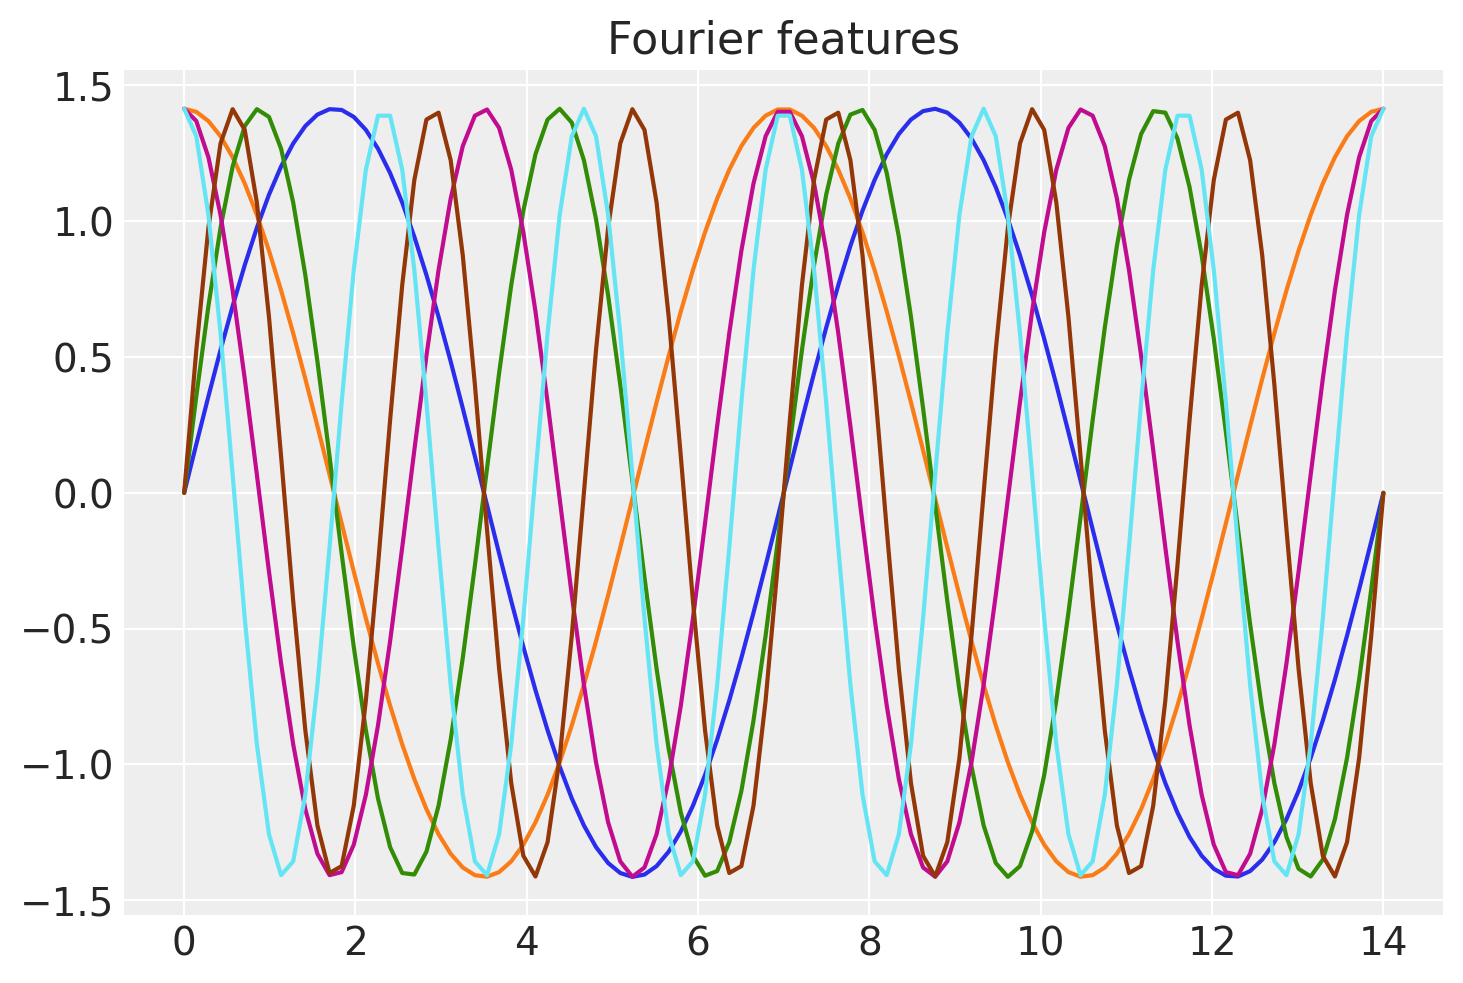

In [35]:
x = np.linspace(0, 14, 100)
plt.plot(x, fourier_series(x, season=Daily.Week).eval())
plt.title("Fourier features");

Now replace the seasonal latent GP with Yearly seasonality as a regression.

```python
alpha = pm.Normal("alpha", 0, sigma, shape=season.order * 2)
features = fourier_series(months, season=season)
seasonality = features @ alpha
```

In [36]:
with pm.Model(coords=dict(time=passengers["Month"])) as model3:
    # copy from the previous model
    m_log_mean = ...
    log_trend = ...
    log_mean = ... # compute from months, log_trend, m_log_mean
    eps = ...

    # time to implement a Fourier Features periodic part
    # priors come first
    # Use a snippet above
    alpha = ...
    seasonality = ...

    pm.Normal("log_obs", log_mean + seasonality, eps, observed=np.log(passengers["#Passengers"]), dims="time")

In [37]:
with model3:
    trace3 = pm.sample()
    trace3.extend(pm.sample_posterior_predictive(trace3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_log_mean, trend, alpha_s, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [log_obs]


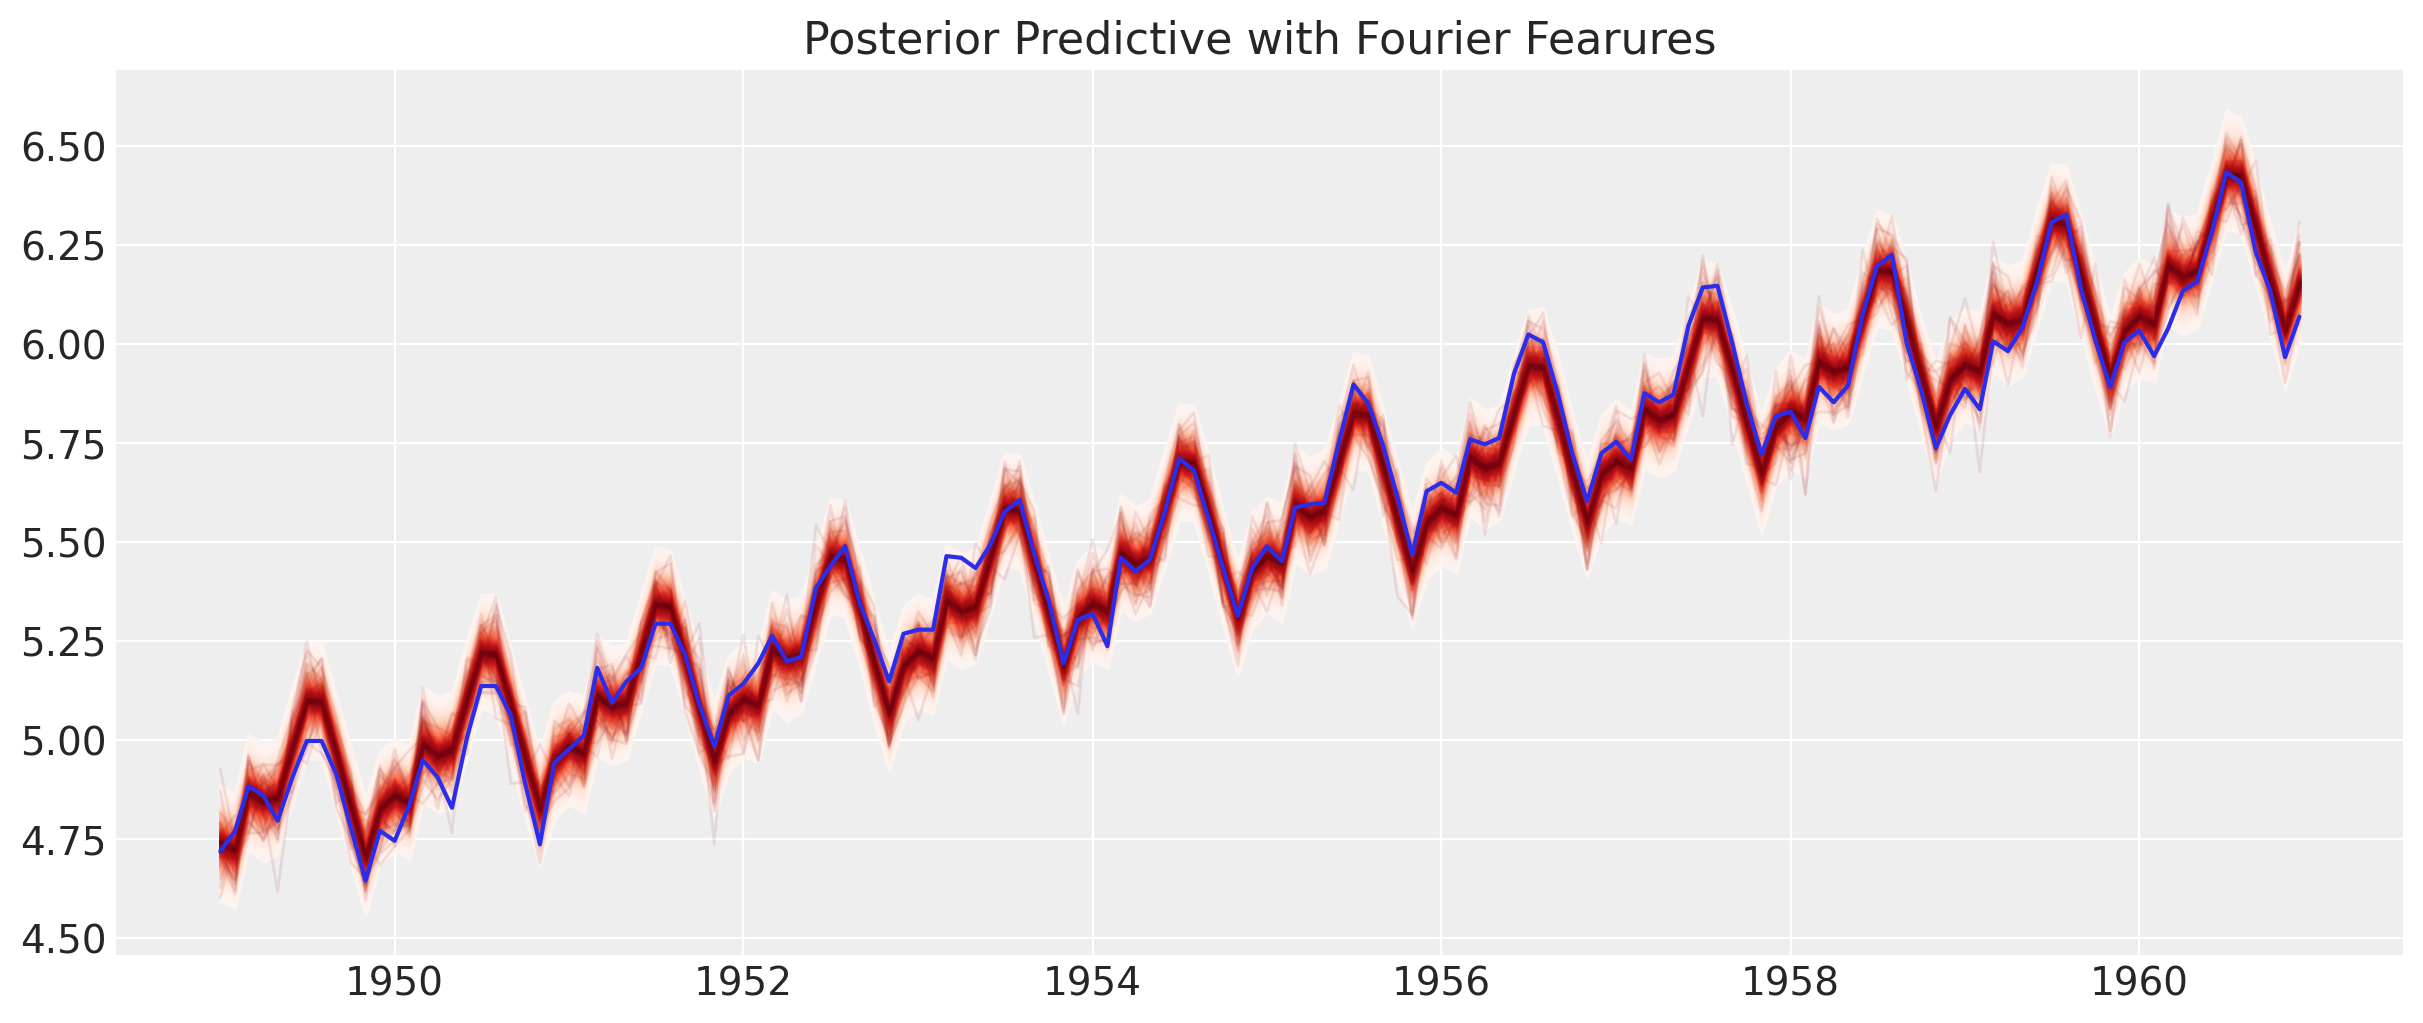

In [72]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()


plot_gp_dist(ax, az.extract(trace3.posterior_predictive)["log_obs"].T, trace3.posterior_predictive.time.values)
ax.plot(trace3.posterior_predictive.time.values, np.log(passengers["#Passengers"]))
plt.title("Posterior Predictive with Fourier Fearures");

## Part 4. HSGP (10pt)
In most cases, a trend and seasonality term do not do much together. Some structural changes may lead to correlated errors (residuals) in time that do not follow any seasonal pattern.

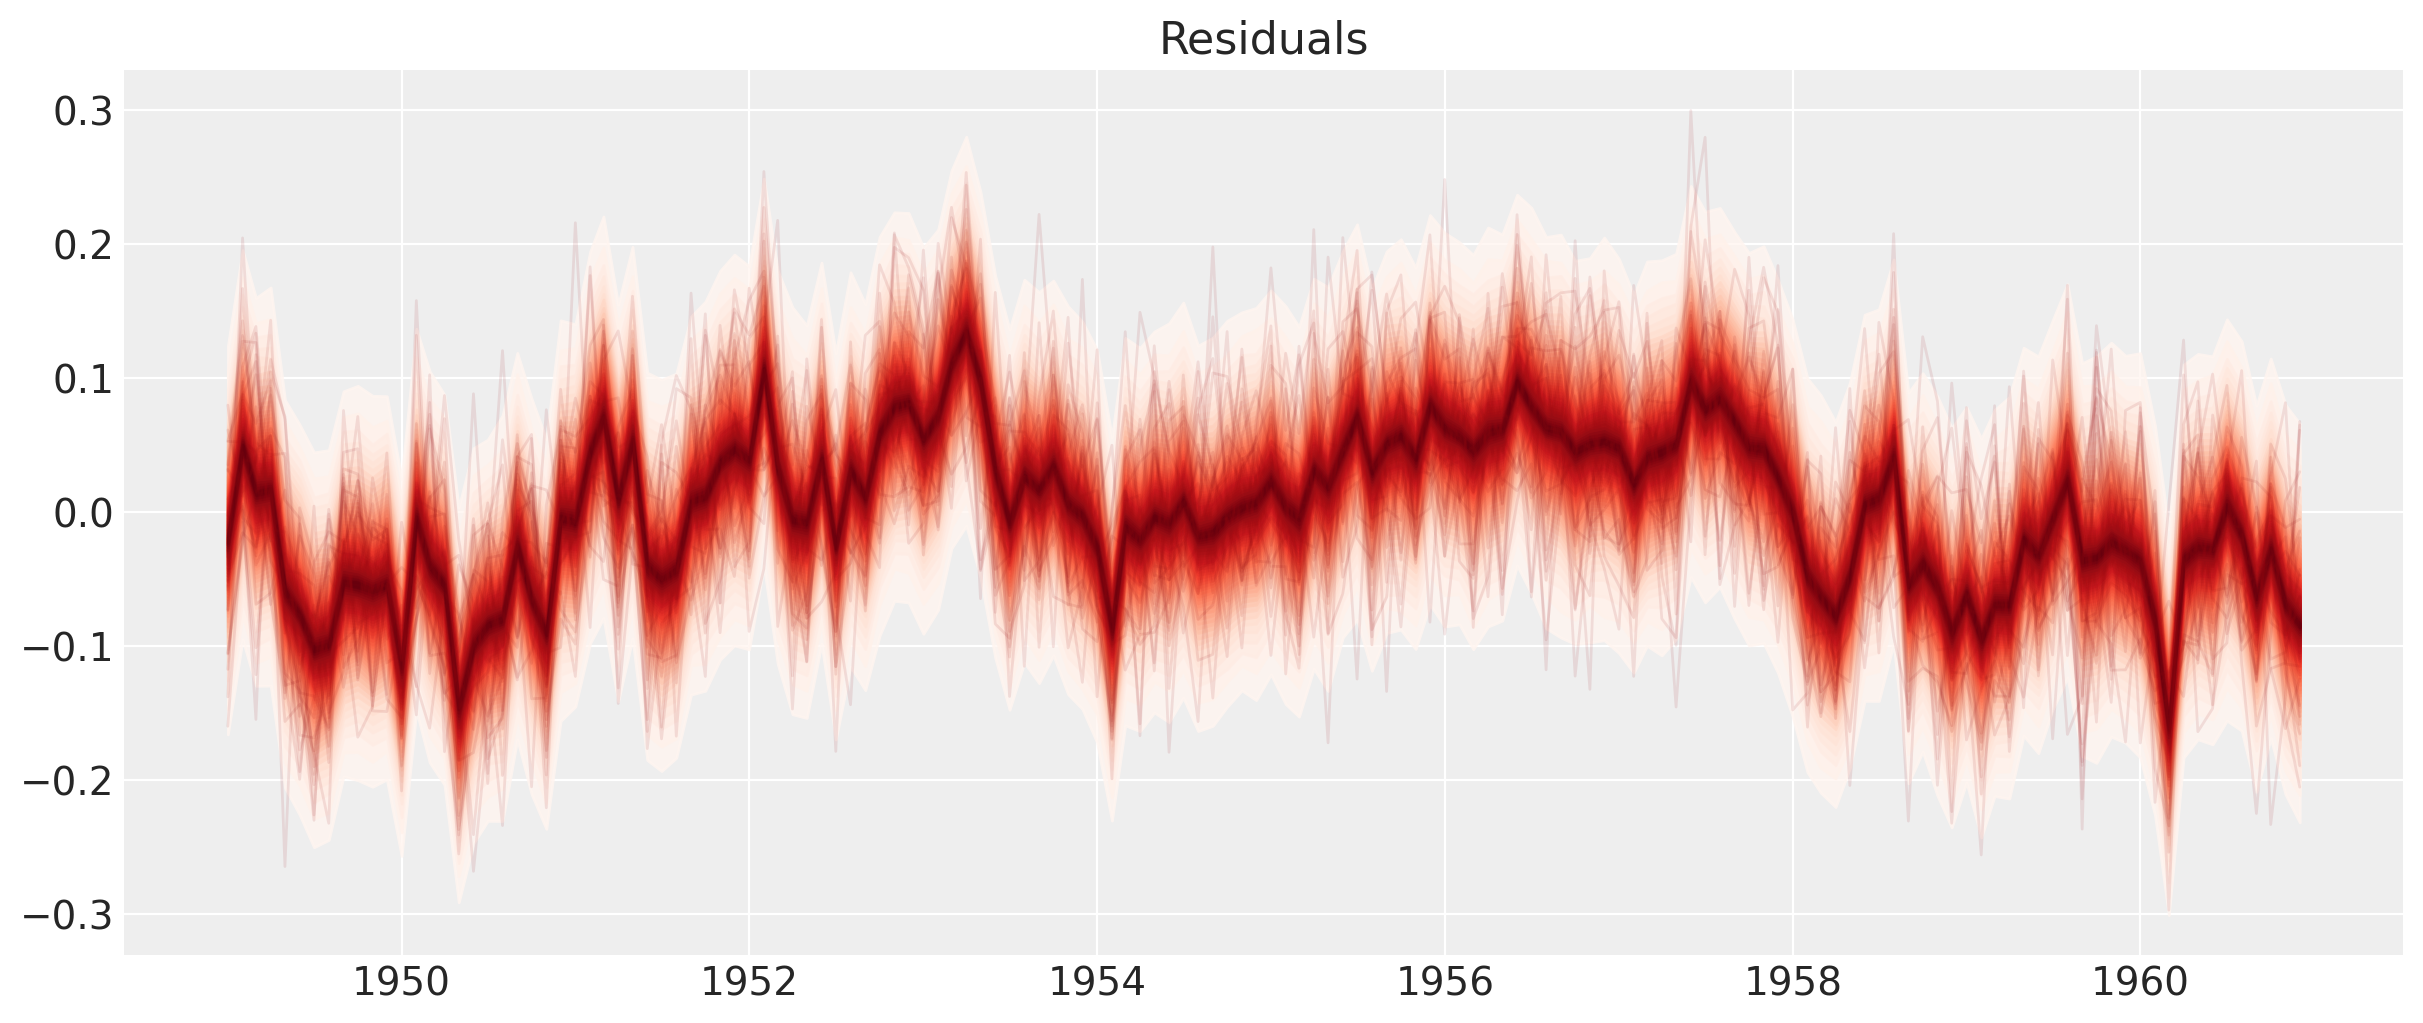

In [40]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

residuals = np.log(passengers["#Passengers"].values) - az.extract(trace3.posterior_predictive)["log_obs"].values.T
plot_gp_dist(ax, residuals, trace3.posterior_predictive.time.values)
plt.title("Residuals");

There exists an approximation to the gaussian process, called HSGP

* https://arxiv.org/abs/2004.11408
* https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html
* https://discourse.pymc.io/t/pymcon-web-series-03a-introduction-to-hilbert-space-gps-hsgps-in-pymc-mar-15-2023-bill-engels/11533

There are not much examples about this yet, the method is very fresh. To make it even more interesting, we'll create a more granular time series, you may think, daily data.

### Under the hood

HSGP is an approximation is frequency domain, we can even see, how the eigenfunctions look like

In [49]:
L = [6] # -L, L is approximation domain
m = [7] # number of basis vectors
X = np.linspace(-5, 5) # data input domain
# eigen vectors of the Laplacian
eig_vals = pm.gp.hsgp_approx.calc_eigenvalues(L, m)
# eigen functions of the Laplacian
eig_vecs = pm.gp.hsgp_approx.calc_eigenvectors(X[:, None], L, eig_vals, m)

In [63]:
eig_vecs.shape

(50, 7)

In [64]:
eig_vals

array([[ 0.27415568,  0.27415568],
       [ 1.09662271,  1.09662271],
       [ 2.4674011 ,  2.4674011 ],
       [ 4.38649084,  4.38649084],
       [ 6.85389195,  6.85389195],
       [ 9.8696044 ,  9.8696044 ],
       [13.43362821, 13.43362821]])

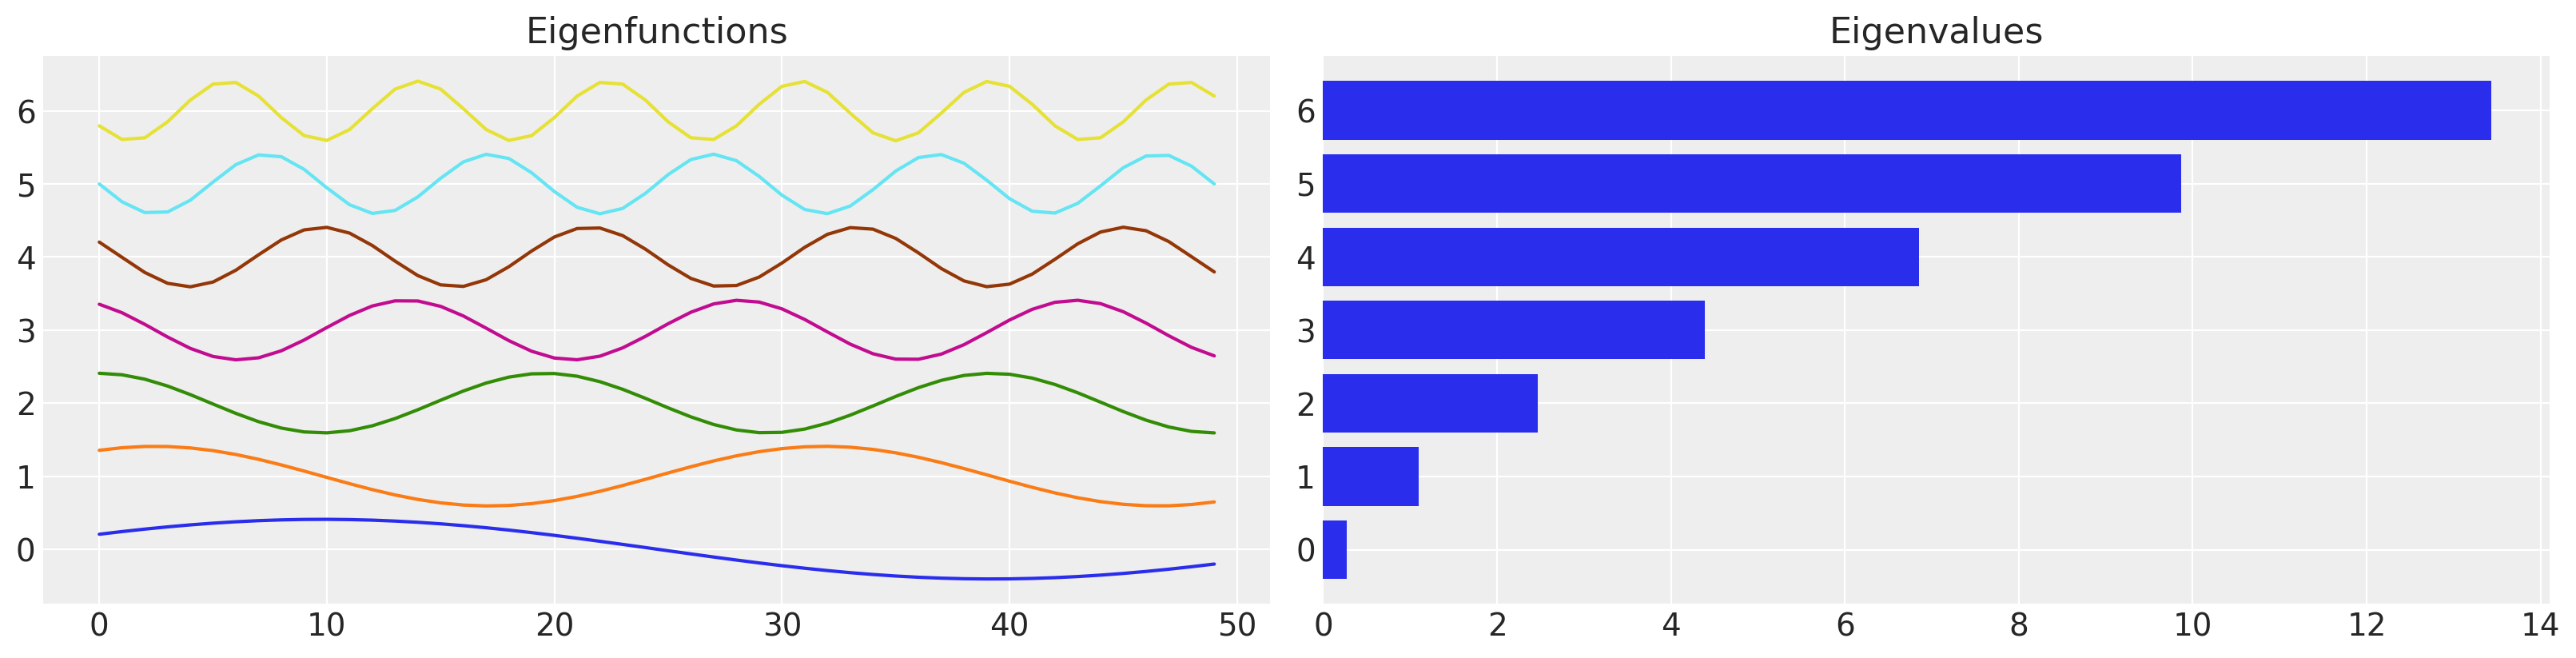

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(eig_vecs + np.arange(m[0]));
axes[0].set_title("Eigenfunctions");
axes[1].barh(np.arange(m[0]), eig_vals[:, 0]);
axes[1].set_title("Eigenvalues");

In [41]:
import scipy.interpolate

In [73]:
interp = scipy.interpolate.interp1d(
    np.arange(len(passengers)), 
    np.log(passengers["#Passengers"]), 
    assume_sorted=True, 
    fill_value="extrapolate"
)
interpolate_log_passengers = interp(np.linspace(0, len(passengers), len(passengers) * 30))

In [92]:
with pm.Model(
    coords=dict(
        time=pd.date_range(
            passengers["Month"].min(), 
            passengers["Month"].max(), 
            len(interpolate_log_passengers)
        ))
) as model4:
    # center data such that E[X] is 0, this is a common practice to simplify reasoning
    months = pm.MutableData(
        "months",
        # divide by 30 since we copy code that was working on monthly scale
        1/30 * (np.arange(len(interpolate_log_passengers)) - len(interpolate_log_passengers)//2), 
        dims="time")
    # copy from the previous model
    m_log_mean = ...
    log_trend = ...
    log_mean = ... # compute from months, log_trend, m_log_mean
    eps = ...

    # time to implement a Fourier Features periodic part
    # priors come first
    # Use a snippet above
    alpha = ...
    seasonality = ...

    # HSGP Time
    ls = ...
    alpha_r = ...
    cov = ...
    assert isinstance(cov, pm.gp.cov.ExpQuad)
    # This is formula from paper to get optimal number of approximation components
    # In this example it can be  5-30 depending on your lengthscale, 
    # if you get 100+, your lengthscalse is questionable
    m = np.ceil(1.75 * 1.25 / 24 * (max_months//2))
    # read https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html
    # to initialize HSGP, use drop_first=True, do not forget (cov * alpha_r) 
    gp = ...
    assert isinstance(gp, pm.gp.HSGP)
    residual = gp.prior("structural", months[:, None], dims="time")

    mean = log_mean + seasonality + residual
    log_obs = pm.Normal("log_obs", mean , eps, observed=interpolate_log_passengers, dims="time")

Sampling may take a while, if it takes too long, try chains=1 as well.

In [95]:
with model4:
    trace4 = pm.sample(chains=1)
    trace4.extend(pm.sample_posterior_predictive(trace4))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [m_log_mean, trend, alpha_s, ls, alpha_r, structural_hsgp_coeffs_, eps]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 334 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [log_obs]


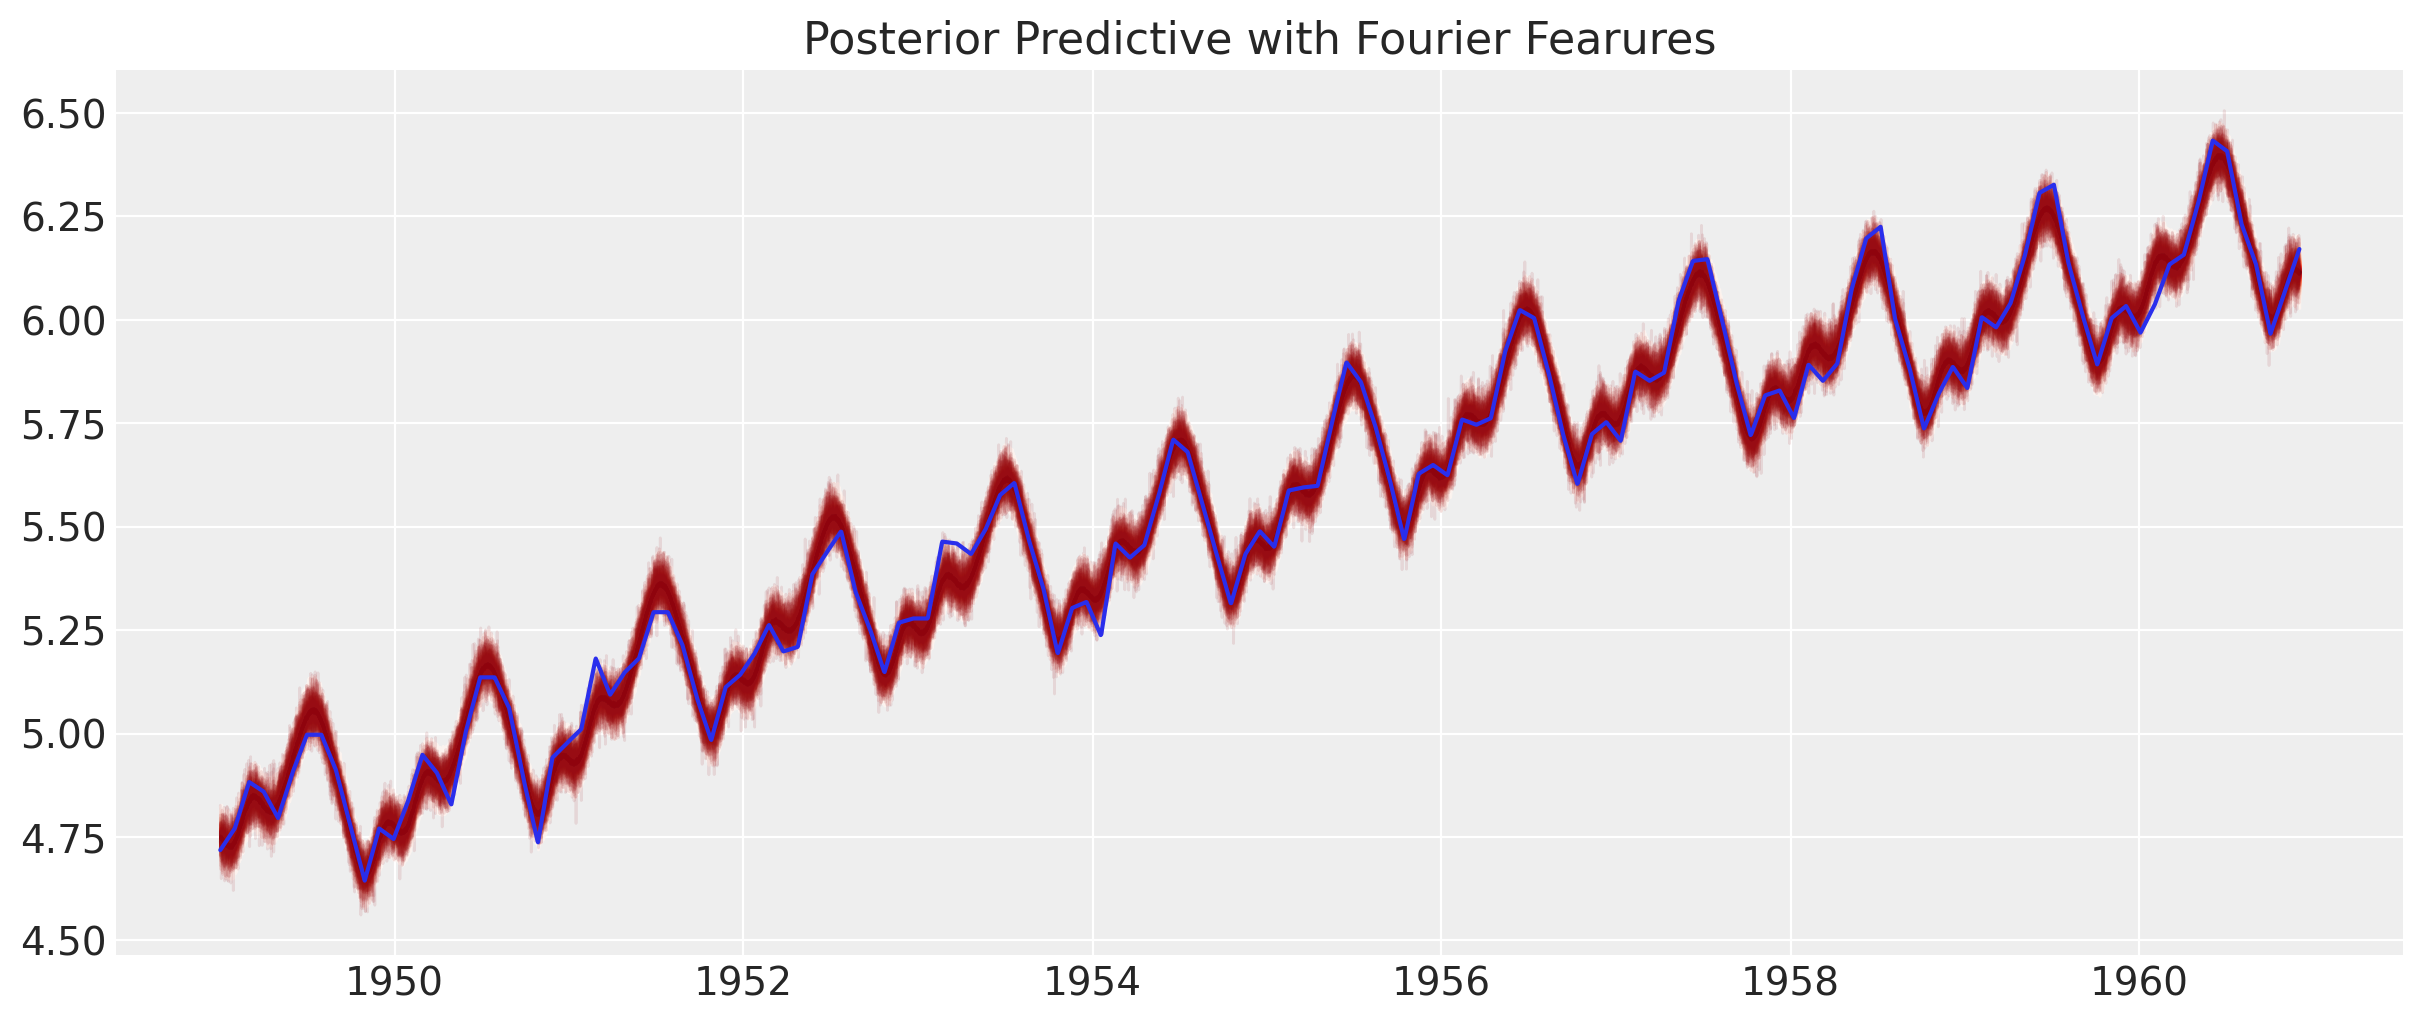

In [96]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()


plot_gp_dist(ax, az.extract(trace4.posterior_predictive)["log_obs"].T, trace4.posterior_predictive.time.values)
ax.plot(trace4.posterior_predictive.time.values, interpolate_log_passengers)
plt.title("Posterior Predictive with Fourier Fearures");

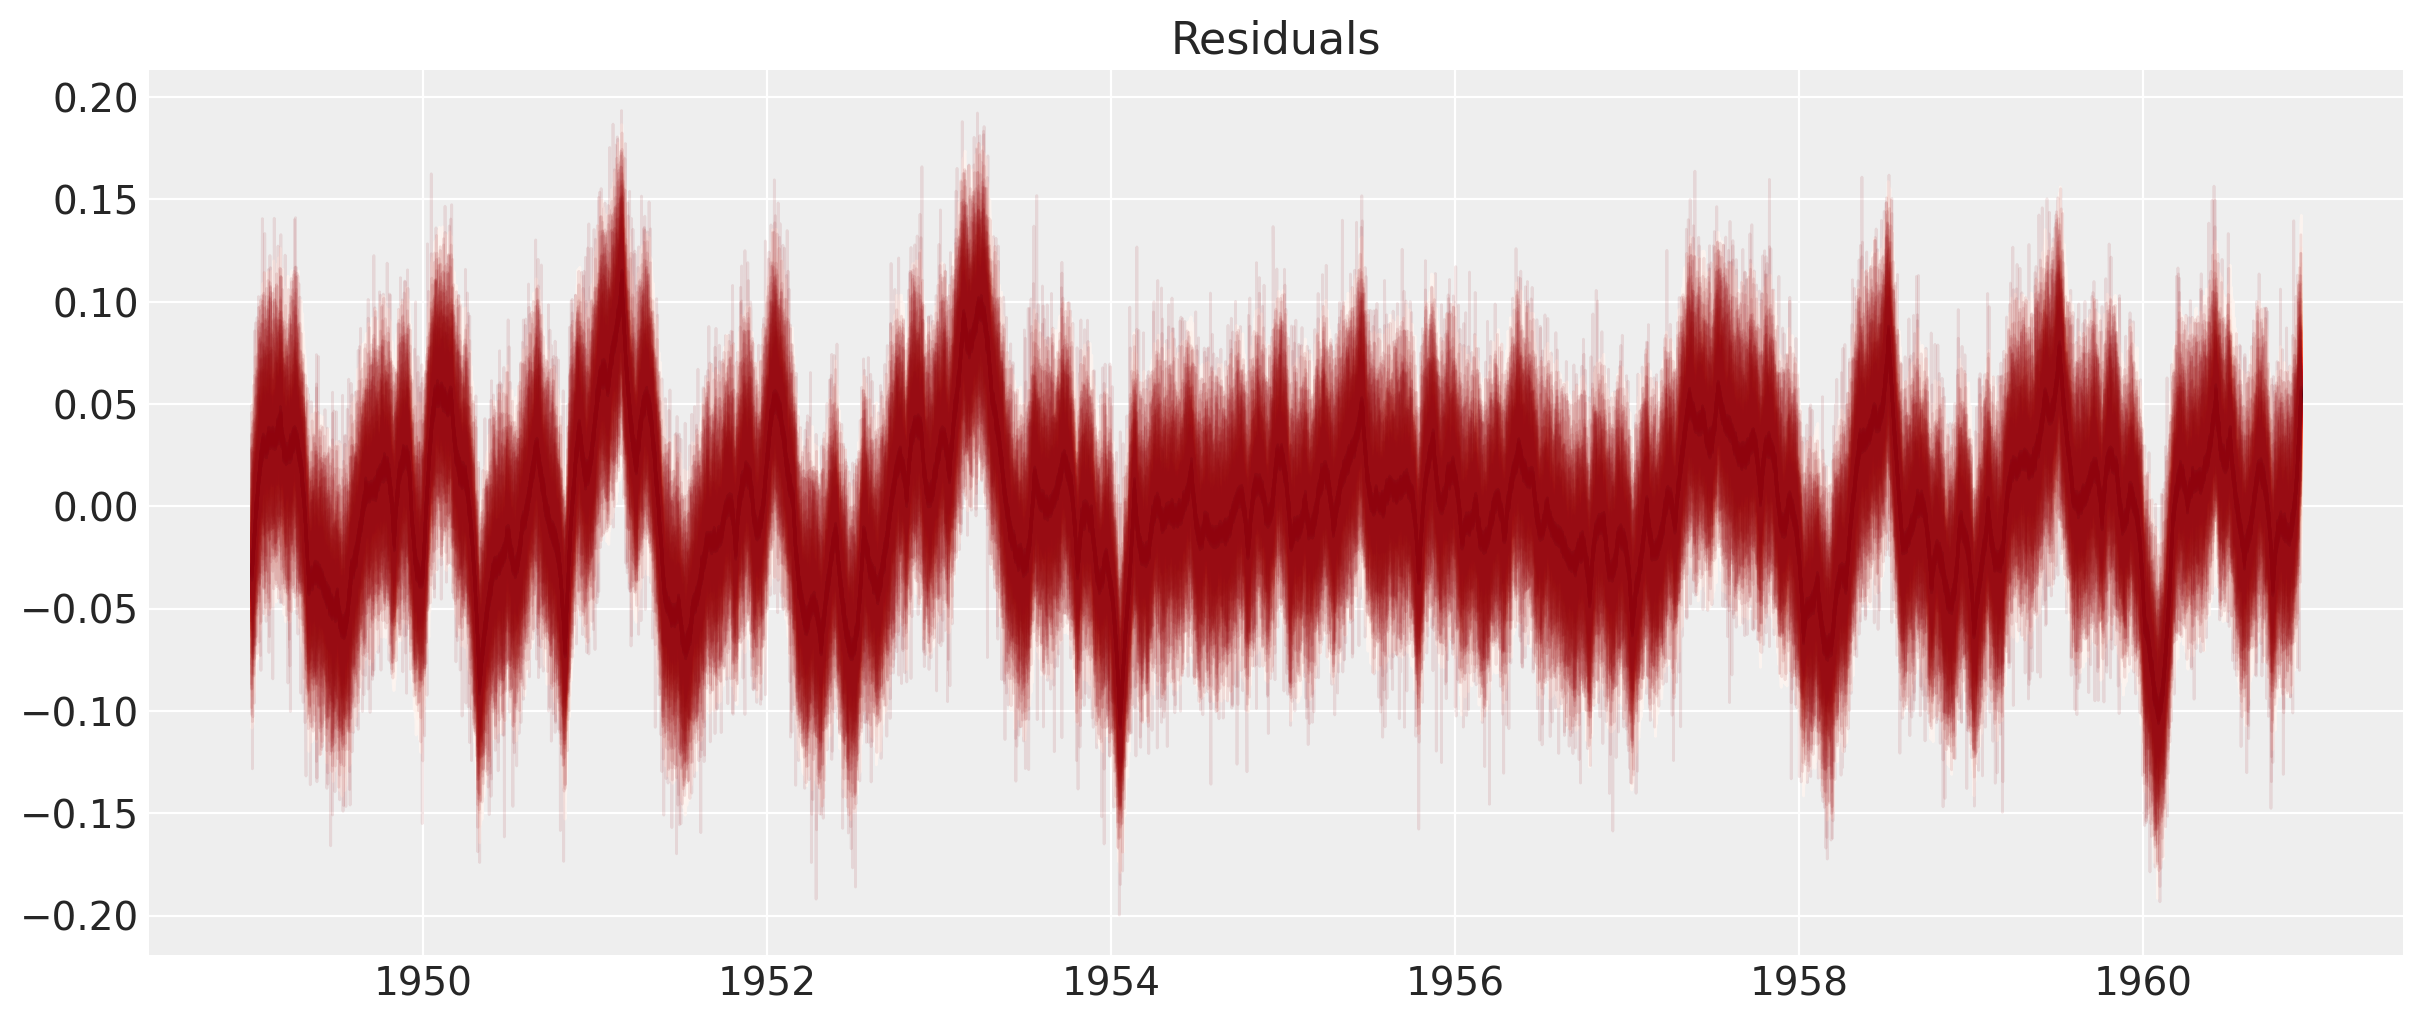

In [97]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

residuals = interpolate_log_passengers - az.extract(trace4.posterior_predictive)["log_obs"].values.T
plot_gp_dist(ax, residuals, trace4.posterior_predictive.time.values)
plt.title("Residuals");